### Sanity check

#### 1. AttAttribute_sim and AvgAtt might be similar in certain conditions

Just in case, visualize some computation graphs

In [1]:
# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
)

from torch_geometric.utils import get_num_hops
from visualization_utils import (
    visualize_computation_graph,
    draw_local_comp_graph_with_ground_truth_path,
)
import torch

# Load the network data locally (for reproduction)
data = torch.load("/workspace/Infection_50002d_sp.pt", map_location="cpu")
# Load model as a whole
model = torch.load("/workspace/GAT_infection_2L1H_sp.pt", map_location="cpu")
model.eval()

GAT_L2_intervention(
  (conv1): GATConv_mask(2, 8, heads=1)
  (conv2): GATConv_mask(8, 4, heads=1)
)

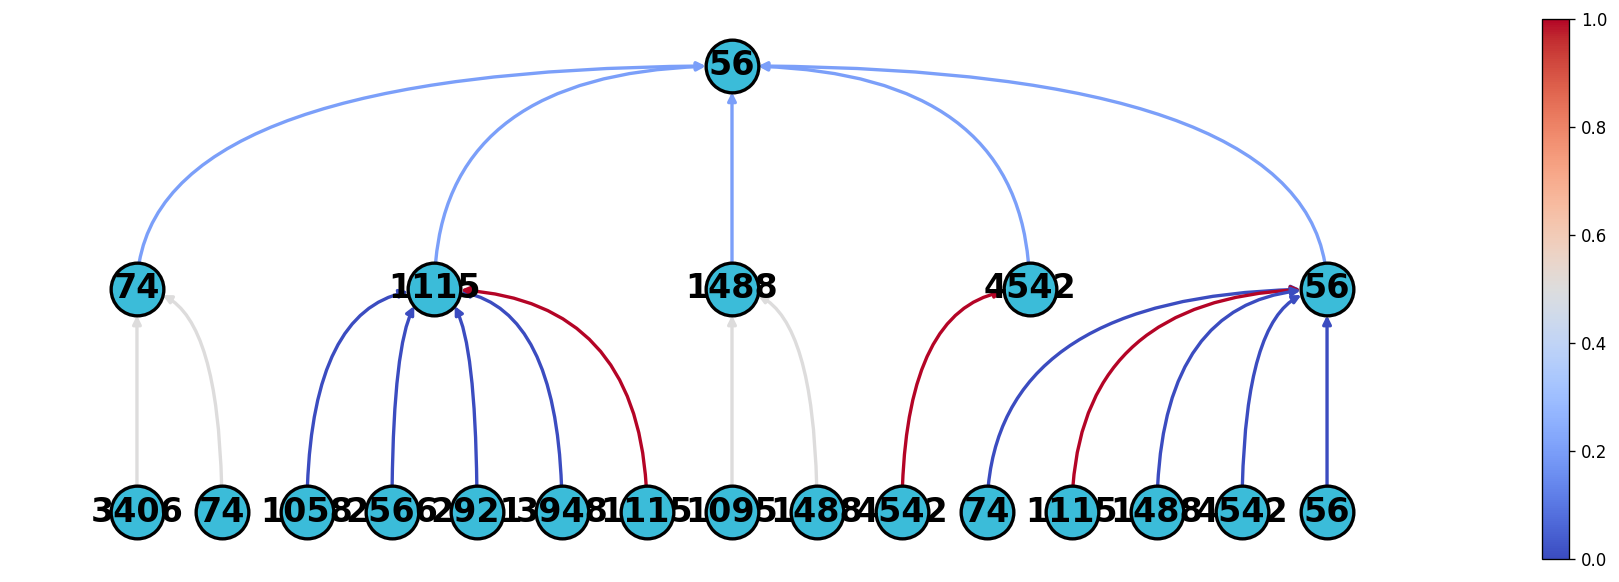

In [2]:
target_idx = 56
num_layers = get_num_hops(model)

att_dict_raw = get_attention_raw_dict(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

In [3]:
att_dict_raw

{0: (tensor([[   0,    0,    1,  ..., 4997, 4998, 4999],
          [ 403, 2608,  757,  ..., 4997, 4998, 4999]]),
  tensor([[0.0022],
          [0.3333],
          [0.0022],
          ...,
          [0.3333],
          [1.0000],
          [0.3333]])),
 1: (tensor([[   0,    0,    1,  ..., 4997, 4998, 4999],
          [ 403, 2608,  757,  ..., 4997, 4998, 4999]]),
  tensor([[9.1317e-10],
          [3.3333e-01],
          [4.1842e-10],
          ...,
          [3.3333e-01],
          [1.0000e+00],
          [3.3333e-01]]))}

In [4]:
att_dict

{0: {(0, 403): 0.002169064013287425,
  (0, 2608): 0.3333333432674408,
  (1, 757): 0.002169064013287425,
  (1, 1929): 0.3333333432674408,
  (2, 190): 0.25,
  (4, 166): 0.0021785146091133356,
  (5, 463): 0.995642900466919,
  (6, 231): 0.002173778833821416,
  (6, 1815): 0.1428571492433548,
  (7, 3237): 0.1666666716337204,
  (8, 1778): 0.25,
  (8, 4337): 0.0021785146091133356,
  (9, 3759): 0.25,
  (10, 1876): 0.1666666716337204,
  (10, 3412): 0.3333333432674408,
  (10, 3967): 0.25,
  (11, 2283): 0.3333333432674408,
  (11, 3069): 0.20000000298023224,
  (12, 400): 0.18504835665225983,
  (12, 1320): 0.002169064013287425,
  (12, 3678): 0.20000000298023224,
  (12, 3798): 0.18504835665225983,
  (12, 4166): 0.5,
  (12, 4948): 0.1666666716337204,
  (13, 4364): 0.20000000298023224,
  (14, 793): 0.9978166818618774,
  (15, 199): 0.9978166818618774,
  (15, 469): 0.995642900466919,
  (15, 708): 0.9913235902786255,
  (16, 138): 0.25,
  (16, 1647): 0.3333333432674408,
  (17, 4669): 0.25,
  (18, 810): 0.0

In [5]:
data.unique_solution_nodes[12]

56

In [6]:
from visualization_utils import draw_local_comp_graph_with_ground_truth_path as draw

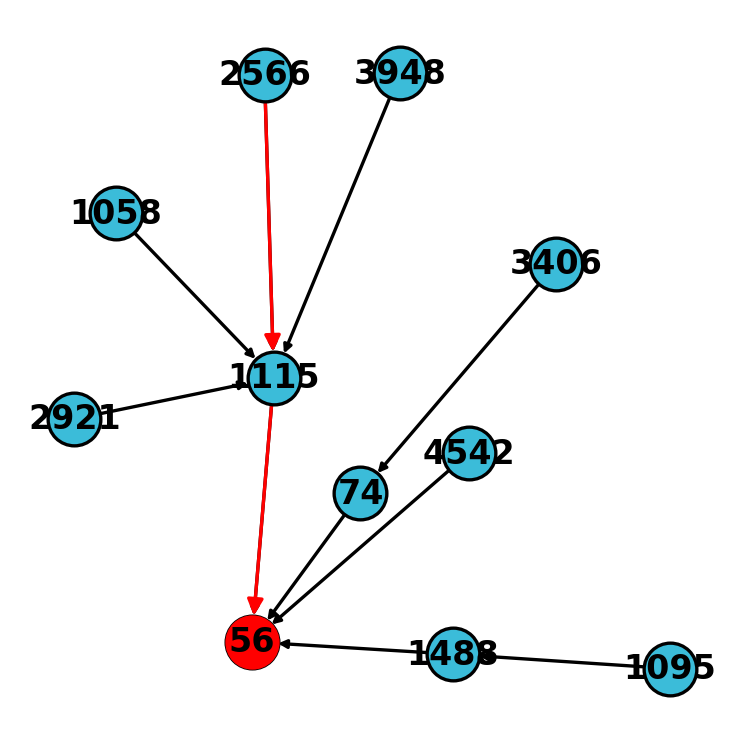

In [7]:
draw(data=data, hops=2, target_idx=target_idx, ground_truth=True)

The goal of this sanity check is to make sure that two attribution (from attention) methods, i.e., AttAttribute_sim (proposed by us) and AvgAtt (naive alternative) are indeed difffernt. Here are some thoughts:
- The reason why I initially thought the two methods may be the same is that the two methods take attention weights at face value. Methodologically, the only difference is that the former uses addition, while the latter uses average.
- In this case, the two methods are identical only if the number of times an edge is considered in attribution calculations are the same, which means that the two methods are basically the same up to a multiplicative constant. This is where I was confused.
- In the final analysis, the two methods are indeed different, because the number of times an edge is considered in attribution calculations are different. 
    - For example, looking at the figure above, the edge (2566, 1115) is counted only **once** in the AttAttribute_sim method, while it is counted **twice** in the AvgAtt method.
    - This is a direct result of the way AttAttribute_sim is designed, where the main difference essentially comes down to the **contextualization** of attribution by *always considering which target node is being explained*.

### Sanity check 2

#### Matrix multiplication calculation of the attribution methods

We need a simpler example for this one

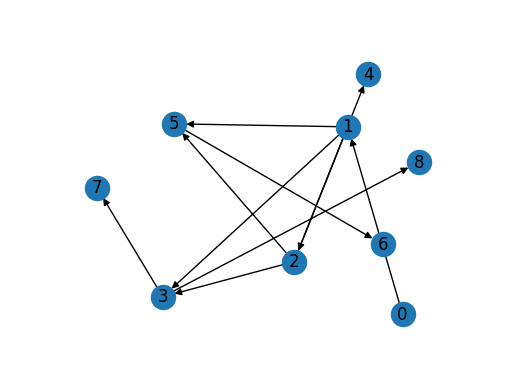

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(
    [(0, 1), (2, 5), (1, 2), (1, 3), (1, 5), (2, 3), (2, 4), (3, 7), (3, 8), (5, 6)]
)

pos = nx.spring_layout(G, seed=10, k=0.1, iterations=00)
nx.draw_networkx(G, pos=pos)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [9]:
G.edges()

OutEdgeView([(0, 1), (1, 2), (1, 3), (1, 5), (2, 5), (2, 3), (2, 4), (5, 6), (3, 7), (3, 8)])

In [10]:
from torch_geometric.data import Data

edge_index = torch.zeros((2, G.number_of_edges()), dtype=torch.long)  # 2 x E
edge_index[0, :] = torch.tensor([e[0] for e in G.edges()])  # source
edge_index[1, :] = torch.tensor([e[1] for e in G.edges()])  # target

data = Data(edge_index=edge_index, num_nodes=G.number_of_nodes())

In [11]:
data.edge_index

tensor([[0, 1, 1, 1, 2, 2, 2, 5, 3, 3],
        [1, 2, 3, 5, 5, 3, 4, 6, 7, 8]])

In [12]:
from torch_geometric.utils import add_self_loops

data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)

In [13]:
from torch_geometric.utils import to_dense_adj

In [14]:
adj = to_dense_adj(data.edge_index).squeeze()

In [15]:
adj

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [16]:
# Generate dummy attention values for a 2-layer GAT
# Self-loops are already added
att_0 = torch.rand(data.num_edges)
att_1 = torch.rand(data.num_edges)
att_2 = torch.rand(data.num_edges)

data.edge_index, att_0, att_1, att_2

(tensor([[0, 1, 1, 1, 2, 2, 2, 5, 3, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8],
         [1, 2, 3, 5, 5, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]]),
 tensor([0.7595, 0.1879, 0.4168, 0.4498, 0.1522, 0.1026, 0.3286, 0.2785, 0.6887,
         0.4749, 0.4421, 0.8540, 0.5031, 0.6490, 0.0484, 0.6848, 0.8767, 0.4194,
         0.6653]),
 tensor([0.2503, 0.5217, 0.9775, 0.1818, 0.2606, 0.5773, 0.4792, 0.8434, 0.5974,
         0.4471, 0.3935, 0.3369, 0.2077, 0.7209, 0.0087, 0.9116, 0.7928, 0.3268,
         0.5894]),
 tensor([0.3914, 0.0564, 0.2881, 0.6375, 0.9948, 0.3424, 0.1334, 0.2882, 0.1887,
         0.4774, 0.4175, 0.1872, 0.3150, 0.9491, 0.0162, 0.9432, 0.4436, 0.5768,
         0.0862]))

In [17]:
att = [(data.edge_index, att_0), (data.edge_index, att_1), (data.edge_index, att_2)]

In [18]:
att

[(tensor([[0, 1, 1, 1, 2, 2, 2, 5, 3, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8],
          [1, 2, 3, 5, 5, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]]),
  tensor([0.7595, 0.1879, 0.4168, 0.4498, 0.1522, 0.1026, 0.3286, 0.2785, 0.6887,
          0.4749, 0.4421, 0.8540, 0.5031, 0.6490, 0.0484, 0.6848, 0.8767, 0.4194,
          0.6653])),
 (tensor([[0, 1, 1, 1, 2, 2, 2, 5, 3, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8],
          [1, 2, 3, 5, 5, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]]),
  tensor([0.2503, 0.5217, 0.9775, 0.1818, 0.2606, 0.5773, 0.4792, 0.8434, 0.5974,
          0.4471, 0.3935, 0.3369, 0.2077, 0.7209, 0.0087, 0.9116, 0.7928, 0.3268,
          0.5894])),
 (tensor([[0, 1, 1, 1, 2, 2, 2, 5, 3, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8],
          [1, 2, 3, 5, 5, 3, 4, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]]),
  tensor([0.3914, 0.0564, 0.2881, 0.6375, 0.9948, 0.3424, 0.1334, 0.2882, 0.1887,
          0.4774, 0.4175, 0.1872, 0.3150, 0.9491, 0.0162, 0.9432, 0.4436, 0.5768,
          0.0862]))]

In [19]:
adj @ adj

tensor([[1., 2., 1., 1., 0., 1., 0., 0., 0.],
        [0., 1., 2., 3., 1., 3., 1., 1., 1.],
        [0., 0., 1., 2., 2., 2., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 2., 2.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [20]:
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)

In [47]:
# Get the results used in our code
target_idx = 6
num_layers = 2

In [48]:
att_dict_raw = {}
for layer in range(num_layers):
    att_dict_raw[layer] = att[layer]

In [49]:
att_dict = process_attention_dict(att_dict_raw)

In [50]:
att_dict

{0: {(0, 1): 0.7594667673110962,
  (1, 2): 0.18785619735717773,
  (1, 3): 0.41680777072906494,
  (1, 5): 0.44982826709747314,
  (2, 5): 0.1521756649017334,
  (2, 3): 0.10263562202453613,
  (2, 4): 0.32861024141311646,
  (5, 6): 0.27850037813186646,
  (3, 7): 0.6887052655220032,
  (3, 8): 0.47486013174057007,
  (0, 0): 0.44210124015808105,
  (1, 1): 0.8540167808532715,
  (2, 2): 0.503143846988678,
  (3, 3): 0.6489912271499634,
  (4, 4): 0.048424482345581055,
  (5, 5): 0.6848340630531311,
  (6, 6): 0.8766912817955017,
  (7, 7): 0.4193829298019409,
  (8, 8): 0.6652551293373108},
 1: {(0, 1): 0.2503352761268616,
  (1, 2): 0.5216881036758423,
  (1, 3): 0.9775386452674866,
  (1, 5): 0.18184047937393188,
  (2, 5): 0.26058244705200195,
  (2, 3): 0.5772691965103149,
  (2, 4): 0.47917866706848145,
  (5, 6): 0.8433592915534973,
  (3, 7): 0.5974307060241699,
  (3, 8): 0.44710665941238403,
  (0, 0): 0.3935105800628662,
  (1, 1): 0.336921751499176,
  (2, 2): 0.20774191617965698,
  (3, 3): 0.72086709

In [51]:
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)

In [52]:
comp_graph

{0: tensor([[5, 6],
         [6, 6]]),
 1: tensor([[1, 2, 5, 5, 6],
         [5, 5, 5, 6, 6]])}

In [53]:
adj + adj @ adj

tensor([[2., 3., 1., 1., 0., 1., 0., 0., 0.],
        [0., 2., 3., 4., 1., 4., 1., 1., 1.],
        [0., 0., 2., 3., 3., 3., 1., 1., 1.],
        [0., 0., 0., 2., 0., 0., 0., 3., 3.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2.]])

In [54]:
data

Data(edge_index=[2, 19], num_nodes=9)

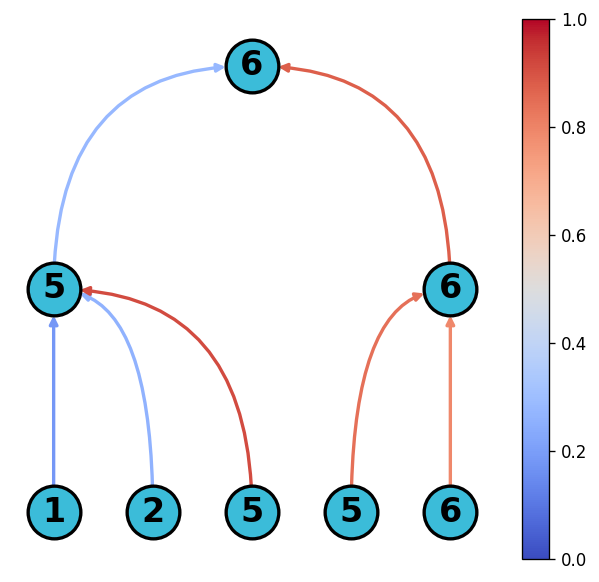

In [55]:
# att_dict_raw = get_attention_raw_dict(model, data)
# att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

In [56]:
adj

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [57]:
adj @ adj

tensor([[1., 2., 1., 1., 0., 1., 0., 0., 0.],
        [0., 1., 2., 3., 1., 3., 1., 1., 1.],
        [0., 0., 1., 2., 2., 2., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 2., 2.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [79]:
torch.ones_like(adj)[0,:]@ adj

tensor([1., 2., 2., 3., 2., 3., 2., 2., 2.])

In [59]:
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)

In [60]:
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)

In [61]:
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)

In [62]:
edge_lists = return_edges_in_k_hop(
    data=data, target_idx=target_idx, hop=2, self_loops=True
)

In [63]:
edge_lists

[[1, 2], [1, 5], [2, 5], [5, 6], [1, 1], [2, 2], [5, 5], [6, 6]]

In [64]:
def get_edge_scores(target_edge, comp_graph, comp_graph_new, layer_att_dict, att):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt

In [65]:
# Get results for all edges in the k-hop neighborhood
attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
for current_edge in edge_lists:
    attattribute, attattribute_sim, avgatt = get_edge_scores(
        target_edge=tuple(current_edge),
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        att=att,
    )
    attattribute_list.append(attattribute)
    attattribute_sim_list.append(attattribute_sim)
    avgatt_list.append(avgatt)

In [66]:
# Now the matrix multiplication way
ATT_0 = torch.zeros_like(adj)
ATT_1 = torch.zeros_like(adj)

for idx, (row, col) in enumerate(att[0][0].t()):
    ATT_0[row][col] = att[0][1][idx]

for idx, (row, col) in enumerate(att[1][0].t()):
    ATT_1[row][col] = att[1][1][idx]

In [67]:
ATT_1

tensor([[0.3935, 0.2503, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3369, 0.5217, 0.9775, 0.0000, 0.1818, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2077, 0.5773, 0.4792, 0.2606, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7209, 0.0000, 0.0000, 0.0000, 0.5974, 0.4471],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0087, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9116, 0.8434, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7928, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3268, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5894]])

In [68]:
avgatt = (ATT_1 + ATT_0) / 2

In [69]:
# Now compare
idx = 1
edge_lists[idx], attattribute_list[idx], attattribute_sim_list[idx], avgatt_list[idx]

([1, 5], 0.05064264226531989, 0.18184047937393188, 0.4230588873227437)

In [70]:
i, j = edge_lists[idx]
dummy = torch.zeros_like(ATT_1)
dummy[i, j] = ATT_0[i, j]
attattribute = torch.matmul(ATT_1, dummy) + ATT_1
attattribute_sim = ATT_0 + ATT_1

In [71]:
attattribute[edge_lists[idx][0], edge_lists[idx][1]], attattribute_sim[
    edge_lists[idx][0], edge_lists[idx][1]
], avgatt[edge_lists[idx][0], edge_lists[idx][1]]

(tensor(0.3334), tensor(0.6317), tensor(0.3158))

In [72]:
attattribute, attattribute_sim, avgatt

(tensor([[0.3935, 0.2503, 0.0000, 0.0000, 0.0000, 0.1126, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3369, 0.5217, 0.9775, 0.0000, 0.3334, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2077, 0.5773, 0.4792, 0.2606, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7209, 0.0000, 0.0000, 0.0000, 0.5974, 0.4471],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0087, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9116, 0.8434, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7928, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3268, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5894]]),
 tensor([[0.8356, 1.0098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.1909, 0.7095, 1.3943, 0.0000, 0.6317, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7109, 0.6799, 0.8078, 0.4128, 0.0000, 0.0000, 0.0000],
  

Maybe we can't reduce this to matrix multiplications...

In [84]:
from torch_geometric.data import Data

edge_index = torch.zeros((2, G.number_of_edges()), dtype=torch.long)  # 2 x E
edge_index[0, :] = torch.tensor([e[0] for e in G.edges()])  # source
edge_index[1, :] = torch.tensor([e[1] for e in G.edges()])  # target

data = Data(edge_index=edge_index, num_nodes=G.number_of_nodes())

In [85]:
adj = to_dense_adj(data.edge_index).squeeze()

In [86]:
adj

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [89]:
adj @ torch.ones_like(adj)[:, 0]

tensor([1., 3., 3., 2., 0., 1., 0., 0., 0.])